# Multiple Regression with Python

***By Alex Borio***

## Introduction

In this article, we will go through the whole process of running a multiple regression in Python. This includes the choice of the relevant packages, inspecting and cleaning data, creating descriptive data, writing the multiple regression model, and interpreting its results. Generally, a multiple regression analysis can be understood as a model that identifies a relationship between one dependent variable and several independent variables, while taking the effects of all independent variables into account. The prediction you receive regarding the change in the dependent variable by one unit increase of a dependent variable is assumed to be linear. That means that no matter how high the dependent or independent variable is, the change is always the same. An example of multiple regression analysis is an analysis of how the number of hours spent for domestic unpaid work is influenced by gender, the number of children in the household, the number of paid hours worked, marital status, and educational level. The dependent variable is the hours of domestic unpaid work, and all the other variables are independent variables. For this example, we use a different example looking at the likelihood to receive admission for a university based on several independent variables. The dataset has 400 entries. Our independent variables are:

- GRE Scores ( out of 340 )
- TOEFL Scores ( out of 120 )
- University Rating ( out of 5 )
- Statement of Purpose (SOP) and Letter of Recommendation (LOR) Strength (out of 5)
- Undergraduate GPA ( out of 10 )
- Research Experience ( either 0 or 1 )
- Chance of Admit ( ranging from 0 to 1 )

## Example

In [1]:
import pandas as pd ## needed for organizing our data
import matplotlib.pyplot as plt ## needed for data visualization
import seaborn as sns ## needed for data visualization
import statsmodels.api as sm ##needed to run the multiple regression
import scipy.stats ## for checking your multiple regression model
from scipy.stats import jarque_bera ##for checking your multiple regression model
import statsmodels.api as sm ## for checking your multiple regression model
from statsmodels.stats.diagnostic import het_breuschpagan ## for checking your multiple regression model
from statsmodels.stats.outliers_influence import variance_inflation_factor ##needed to test for multicollinearity

### Data Inspection and Cleaning
In the next step, we load our dataset and print some general information about it, such as column names, shape, number of NAs, and the datatypes of the column.

In [3]:
df = pd.read_csv("./input/adm_data.csv") # Make sure you fill in the correct working directory to let python know where the data is. I have here made an exemplary path.
print(df.columns) # Shows the columns
print(df.shape) # Tells you the number of rows and columns (first rows, then columns)
print(df.isnull().sum()) # Tells you the number of missing values per column
print(df.dtypes) # Tells you the data types

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')
(400, 9)
Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64
Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Chance of Admit      float64
dtype: object


In [4]:
print(df.head) # You can see here the first five and the last five rows to check the structure of the data

<bound method NDFrame.head of      Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0             1        337          118                  4  4.5   4.5  9.65   
1             2        324          107                  4  4.0   4.5  8.87   
2             3        316          104                  3  3.0   3.5  8.00   
3             4        322          110                  3  3.5   2.5  8.67   
4             5        314          103                  2  2.0   3.0  8.21   
..          ...        ...          ...                ...  ...   ...   ...   
395         396        324          110                  3  3.5   3.5  9.04   
396         397        325          107                  3  3.0   3.5  9.11   
397         398        330          116                  4  5.0   4.5  9.45   
398         399        312          103                  3  3.5   4.0  8.78   
399         400        333          117                  4  5.0   4.0  9.66   

     Research  Chance

### Data Visualization
We can see that in this case, the dataset does not contain any NA values ("not available", values that are missing), which is why we can skip the step of dropping or filling in the missing values. In the next step, we are going to do a first visualization of our data. To keep it simple, we are going to leave out the categorical data (LOR, SOP & University Ranking). However, to use categorical data in the case of a regression, the variables could be coded into dummy variables containing 1 & 0's.

c:\Users\Alex Borio\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


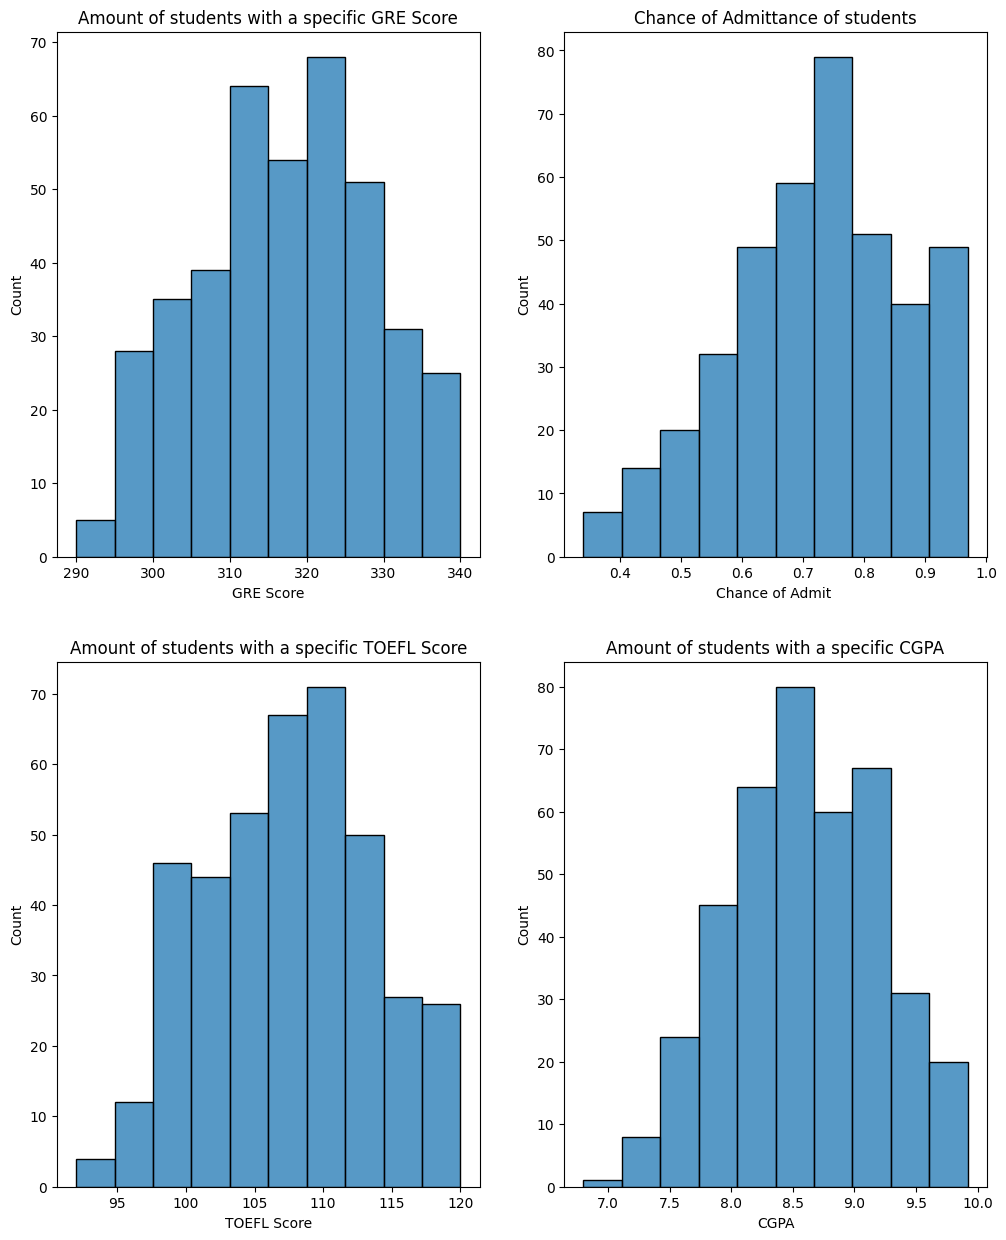

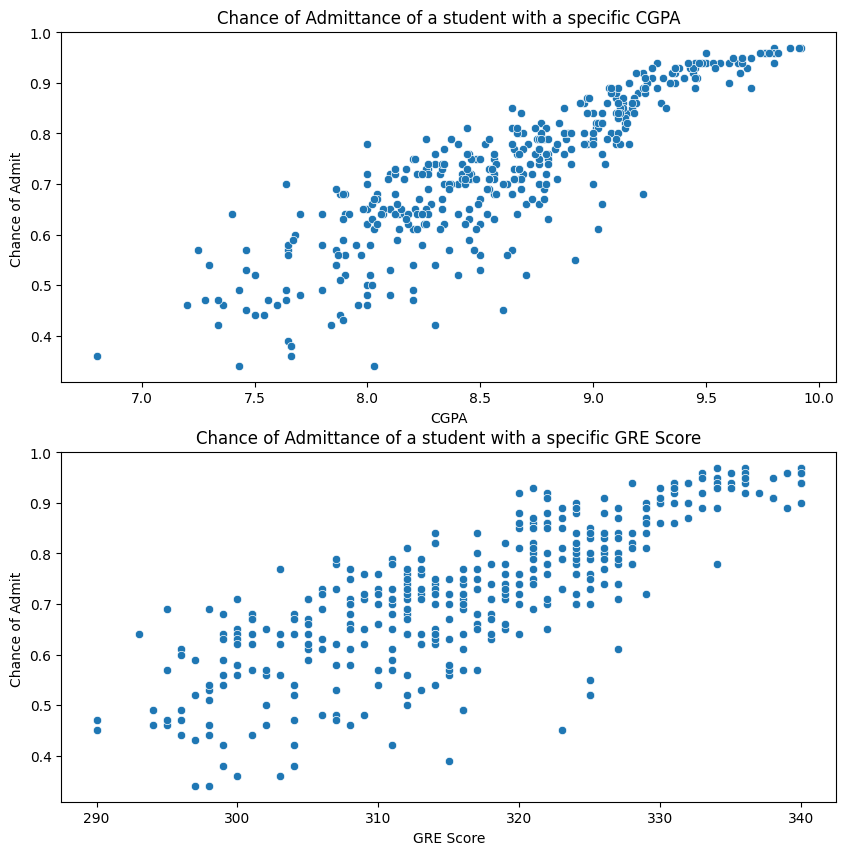

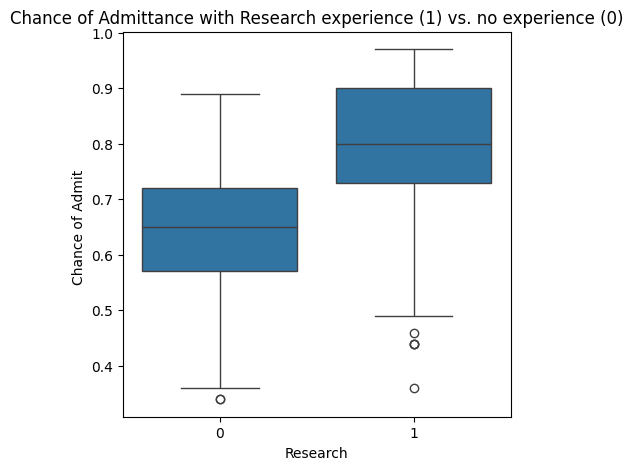

In [5]:
fig, axs = plt.subplots(2, 2, figsize = (12,15))
sns.histplot(ax=axs[0, 0], data=df, x="GRE Score", bins = 10).set(title="Amount of students with a specific GRE Score")
sns.histplot(ax=axs[1, 0], data=df, x="TOEFL Score", bins = 10).set(title="Amount of students with a specific TOEFL Score")
sns.histplot(ax=axs[1, 1], data=df, x="CGPA", bins = 10).set(title="Amount of students with a specific CGPA")
sns.histplot(ax=axs[0, 1], data=df, x="Chance of Admit ", bins = 10).set(title="Chance of Admittance of students")

fig, axs = plt.subplots(2,1, figsize = (10,10))
sns.scatterplot(ax = axs[0], data = df, x = "CGPA", y= "Chance of Admit ").set(title="Chance of Admittance of a student with a specific CGPA")
sns.scatterplot(ax = axs[1], data = df, x = "GRE Score", y= "Chance of Admit ").set(title="Chance of Admittance of a student with a specific GRE Score")

fig, axs = plt.subplots(figsize = (5,5))
sns.boxplot(data = df, x="Research", y = "Chance of Admit ").set(title="Chance of Admittance with Research experience (1) vs. no experience (0)")
plt.show()

The Histograms visualize the distribution of the continuous variables TOEFL Score, GRE Score, CGPA and the Chances of Admittance. Here, they are used to check whether our data is roughly normally distributed. In the scatter plot, we can do a first analysis of the relationship between the variables CGPA and GRE Scores and the Chances of Admittance. The plots showcase that there could be a significant linear relationship between the variables. Lastly, the boxplot is used to look at the only categorical variable left, which is Research. The variable is coded with 0 and 1, to indicate whether a student already has some research experience or not. Based on the boxplots, the variable Research might have a significant impact on the chance of admittance. Therefore, we include the variable in the regression later.

To test the continuous variables for possible correlations, we use the seaborn heatmap function to visualize the correlation between multiple variables. With this tool, we can also check for possible multicollinearity of the variables, so correlation among the independent variables. The scale on the right shows the correlation coefficient ranging from +1 to -1.

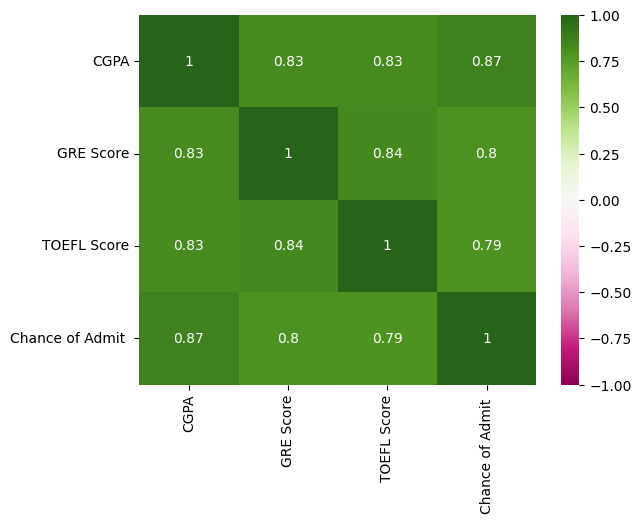

In [6]:
df_continous = df[["CGPA","GRE Score", "TOEFL Score", "Chance of Admit "]]
sns.heatmap(df_continous.corr(), vmin=-1, vmax=1, annot=True, cmap = "PiYG")
plt.show()

We can see in the heatmap that all the variables are highly correlated with each other. Another tool we can use to check for multicollinearity is the Variance Inflation Factor. To test for multicollinearity using the VIF score, we create a new table containing the variables and the VIF. To calculate the score, the variance_inflation_factor function from the statsmodels module is used.

In [7]:
data = df[["CGPA", "TOEFL Score", "GRE Score"]]
vif_data = pd.DataFrame()
vif_data["feature"] = data.columns

for i in range(len(data.columns)):
    vif_data["VIF"] = variance_inflation_factor(data.values, i)

print(vif_data)

       feature         VIF
0         CGPA  994.365812
1  TOEFL Score  994.365812
2    GRE Score  994.365812


One recommendation for the VIF score is interpreting a score higher than 5 on a variable as a sign that this variable is correlated with the other given variables. As expected based on the heatmap, all of the variables have a high VIF score, which we interpret as high multicollinearity. Therefore, we drop 2 of the 3 variables for the linear regression. In this case, the GRE Score and the TOEFL Score are dropped.

### Regression Analysis
Now we can do the regression analysis. We use the variables CGPA and Research as predictor or independent variables for the model and the Chance of Admittance variable as our dependent variable. If we get a meaningful and significant model in the end, it allows us to make predictions on the chances of admittance of a student based on their CGPA and whether they already have some research experience or not.

In [8]:
x = df[["CGPA", "Research"]]
x = sm.add_constant(x) 
y = df["Chance of Admit "]

model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Chance of Admit    R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     686.6
Date:                Fri, 21 Jun 2024   Prob (F-statistic):          1.34e-129
Time:                        10:57:26   Log-Likelihood:                 510.97
No. Observations:                 400   AIC:                            -1016.
Df Residuals:                     397   BIC:                            -1004.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9486      0.055    -17.172      0.0

### Interpretation of the Regression Results

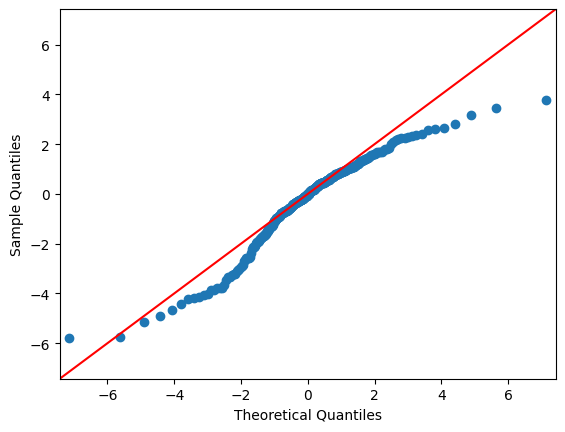

In [9]:
residuals = model.resid
fig = sm.qqplot(residuals, scipy.stats.t, fit=True, line="45")
plt.show()

This can also be tested using the Jarque-Bera test. A Jarque-Bera test compares the kurtosis und skewness of the distribution of your variable with the properties a normal distribution has. The lower the value of the Jarque-Bera test, the more likely the residuals are normally distributed. If the p-value is above your chosen significance level (e.g., 0.05), you can assume that your residuals are normally distributed.

In [10]:
jarque_bera(df["CGPA"])

SignificanceResult(statistic=3.9342882997555417, pvalue=0.13985569333336265)

As you can see, the value of the Jarque-Bera test is quite small and the p-value is even above 0.1. It can therefore not be said that the residuals do not follow a normal distribution. Instead, we assume that your variable CGPA follows a normal distribution. Note that you cannot do the test for binary variables since the Jarque-Bera test assumes that the distribution of residuals is continuous.

Next, we should test for heteroscedasticity. In our regression model, we have assumed homoscedasticity which means that the variance of the residuals is equally distributed. The residuals are the difference between your observations from your predictions. If this is not the case, you have heteroscedasticity. This is often the case because of outliers or skewness in the distribution of a variable. You can assess this visually by plotting the variance of your residuals against an independent variable. Again here, this only makes sense for continuous variables, which is why we look at GCPA.

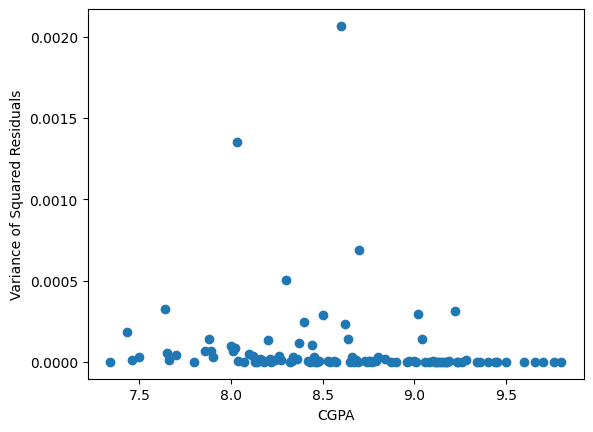

In [11]:
# Calculate the residuals
residuals = model.resid

# Calculate the squared residuals ( to only have positive values)
squared_resid = residuals ** 2

# Group the squared residuals by the values of each independent variable
grouped_resid = squared_resid.groupby(x['CGPA'])

# Calculate the variance of the squared residuals for each group
var_resid = grouped_resid.var()

# Plot the variance of the squared residuals against the values of each independent variable
plt.scatter(var_resid.index, var_resid.values)
plt.xlabel('CGPA')
plt.ylabel('Variance of Squared Residuals')
plt.show()

We can see that there are some outliers that might cause heteroscedasticity. We can also check this with the Breusch-Pagan test. If the p-value is lower than your chosen significance level (e.g., 0.05), we need to reject the null hypothesis that we have homoscedasticity. We would then treat the model to be heteroscedastic.

In [12]:
# Create the multiple regression model
x = df[["CGPA"]]
x = sm.add_constant(x) 
y = df["Chance of Admit "]

model = sm.OLS(y, x).fit()

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(model.resid, model.model.exog)

# Print the results
print("Breusch-Pagan test p-value:", bp_test[1])

Breusch-Pagan test p-value: 9.737203223656916e-06


The test shows that we need to reject the assumption of homoscedasticity. We assume heteroscedasticity. Before we adapt the model, we should also check for serial correlation. Serial correlation is the case in which error terms across time or observations are correlated (in our case across observations). If we look at our regression output again, we can check for this using the Durbin-Watson test statistic. Generally speaking, if the value is around 2, there is no serial correlation, if it is 0, there is a perfect positive serial correlation, if it is 4, there is a perfect negative correlation. The exact values for the number of independent variables and observations you can find here. Our Durbin-Watson test value is 0.839 and we therefore have reason to assume a positive serial correlation. We therefore need to correct for this telling that there is serial correlation (covariance type of H3).

In [13]:
x = df[["CGPA", "Research"]]
x = sm.add_constant(x) 
y = df["Chance of Admit "]

model = sm.OLS(y, x)

nw_model = model.fit(cov_type='HAC', cov_kwds={'maxlags': 20})

# print the results
print(nw_model.summary())

                            OLS Regression Results                            
Dep. Variable:       Chance of Admit    R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     376.5
Date:                Fri, 21 Jun 2024   Prob (F-statistic):           2.03e-92
Time:                        10:59:54   Log-Likelihood:                 510.97
No. Observations:                 400   AIC:                            -1016.
Df Residuals:                     397   BIC:                            -1004.
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9486      0.079    -11.952      0.0

HAC corrects for heteroscedastic and the additional information "cov_kwds={'maxlags': 20)" corrects for serial correlation. As a rule of thumb for our data, you can set the lags to half of your dataset size or the square root. In our case, this makes no difference. You can check it out. If you have the case of serial correlation in another dataset (especially if you have time series data), you might have to perform other analytical tasks to get the correction right. Here is a good start for that. As you can see in the results, nothing has really changed. Even though this seems odd and it seemed like a lot of unnecessary work, it is important to do these diagnostic checks and correct your model if needed. In another regression model, you might get completely different results after e.g., correcting for heteroscedasticity.